In [2]:
import math
import random
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import numba
import numpy.random
from collections import deque

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [9]:
class GridWorld:
    def __init__(self, taille=[4, 4], position_start=[0, 1], good_end_position=[3, 2], bad_end_position=[0, 3]):
        self.current_state = position_start  # État actuel (ligne, colonne)
        self.states = [[x, y] for x in range(taille[0]) for y in range(taille[1])]
        self.end_good_state = good_end_position  # État final (ligne, colonne)
        self.end_bad_state = bad_end_position
        self.grid_size = taille  # Taille de la grille (lignes, colonnes)
        self.stateSpace = {}
        self.matchStates()
        self.currentIntState = self.getStateInt(self.current_state)
        self.num_actions = 4  # Nombre total d'actions possibles (haut, bas, gauche, droite)
        self.reward = 0  # Récompense actuelle
        self.done = False  # Indique si la partie est terminée
        self.generate_grid()
        self.actions = [0, 1, 2, 3]
        self.rewards = [0, 1, 3]
        self.actionSpace = {0: -self.grid_size[0], 1: self.grid_size[0],
                            2: -1, 3: 1}

    def state_description(self):
        return np.array([self.currentIntState / (len(self.states) - 1) * 2.0 - 1.0])

    def state_dim(self):
        return len(self.state_description())

    def reset(self):
        self.done = False
        self.current_state = [np.random.randint(0, self.grid_size[0] - 1), np.random.randint(0, self.grid_size[1] - 1)]
        self.currentIntState = self.getStateInt(self.current_state)
        self.reward = 0

    def matchStates(self):
        i = 0
        for s in self.states:
            self.stateSpace[str(s)] = i
            i = i + 1

    def getStateInt(self, st):
        return self.stateSpace[str(st)]

    def getStateCouple(self, st):
        n_state = {i for i in self.stateSpace if self.stateSpace[i] == st}
        return list(n_state)

    def step(self, action):
        if action == 0:
            if self.current_state[0] == 0:
                self.current_state[0] = self.grid_size[0] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour traverser le mur
                #self.generate_grid()
                self.endgame()
            else:
                self.current_state[0] = self.current_state[0] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                #self.generate_grid()
                self.endgame()

        elif action == 1:
            if self.current_state[0] == self.grid_size[0] - 1:
                self.current_state[0] = 0
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[0] = self.current_state[0] + 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                #self.generate_grid()
                self.endgame()

        elif action == 2:
            if self.current_state[1] == 0:
                self.current_state[1] = self.grid_size[1] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                #self.generate_grid()
                self.endgame()
            else:
                self.current_state[1] = self.current_state[1] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                #self.generate_grid()
                self.endgame()

        elif action == 3:
            if self.current_state[1] == self.grid_size[1] - 1:
                self.current_state[1] = 0
                self.currentIntState = self.getStateInt(self.current_state)
                # print(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                #self.generate_grid()
                self.endgame()
            else:
                self.current_state[1] = self.current_state[1] + 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                #self.generate_grid()
                self.endgame()
                # Si l'on atteint l'état final, la partie est terminée
        return self.currentIntState, self.reward, self.done

    def endgame(self):
        if self.current_state == self.end_good_state:
            self.reward = 10  # Récompense de 10 pour atteindre l'état final
            self.done = True
            print("Une bonne récompense")
        elif self.current_state == self.end_bad_state:
            self.reward = -10
            self.done = True
            print("Une mauvaise récompense")

    def generate_grid(self):
        grid = []
        for i in range(self.grid_size[0]):
            grid.append([])
            for j in range(self.grid_size[1]):
                grid[i].append("_")
        grid[self.current_state[0]][self.current_state[1]] = "X"
        for i in grid:
            print(i)
        print("\n")

In [4]:
def build_compile_model(env):
    model = tf.keras.models.Sequential()
    model.add(Dense(24, input_dim=1, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(len(env.actions), activation='linear'))

    model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
    return model

In [5]:
def ddqn(env, max_iter=1000, gamma=0.99, alpha=0.1, epsilon=0.1):
    q_network = build_compile_model(env)
    target_network = build_compile_model(env)
    nb_steps = 0
    first_episode = True
    
    cumumated_reward = 0
    step = 0
    reward = 0
    reward_per_episode = []
    step_by_episode = []
    batch_size = 32
    memory = deque(maxlen=2000)
    
    for iteretion in range(max_iter):
        print("Iteration : ", iteretion)
        if env.done:
            reward_per_episode.append(env.reward)
            step_by_episode.append(step)
            env.reset()
            step = 0
            cumumated_reward = 0
        
        
        actions = env.actions
        current_state = env.currentIntState
        q_values = q_network.predict(np.array([current_state]))[0]
        if np.random.rand() < epsilon:
            a = np.random.choice(actions)
        else:
            a= np.argmax(q_values)

        old_reward = env.reward
        new_state, reward, done = env.step(a)
        memory.append((old_reward, a, reward, new_state, done))
            
        if done:
                q_values[a] = reward
        else:
            t = target_network.predict(np.array([new_state]))[0]
            q_values[a] = reward + gamma * np.amax(t)
        q_network.fit(np.array([current_state]), np.array([q_values]), verbose=0)
            
        cumumated_reward += reward
        step += 1

        if done:
            target_network.set_weights(q_network.get_weights())
                
    return reward_per_episode, step_by_episode

['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


Iteration :  0
1/1 [==============================] - 0s 160ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 121ms/step
Iteration :  1
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 37ms/step
Iteration :  2
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


1/1 [==============================] - 0s 45ms/step
Iteration :  3
1/1 [==============================] - 0s 53ms/step
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


Une mauvaise récompense
Iteration :  4
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', 

1/1 [==============================] - 0s 39ms/step
Iteration :  80
1/1 [==============================] - 0s 51ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 60ms/step
Iteration :  81
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 58ms/step
Iteration :  82
1/1 [==============================] - 0s 81ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 52ms/step
Iteration :  83
1/1 [==============================] - 0s 60ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 56ms/step
Iteration :  84
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_'

1/1 [==============================] - 0s 36ms/step
Iteration :  120
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  121
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 40ms/step
Iteration :  122
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  123
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  124
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_'

1/1 [==============================] - 0s 41ms/step
Iteration :  160
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 36ms/step
Iteration :  161
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 48ms/step
Iteration :  162
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 35ms/step
Iteration :  163
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 36ms/step
Iteration :  164
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_'

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 38ms/step
Iteration :  200
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 34ms/step
Iteration :  201
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 36ms/step
Iteration :  202
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 36ms/step
Iteration :  203
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 40ms/step
Iteration :  204
1/1 [============

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 33ms/step
Iteration :  279
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 38ms/step
Iteration :  280
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 42ms/step
Iteration :  281
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  282
1/1 [==============================] - 0s 50ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  283
1/1 [============

1/1 [==============================] - 0s 67ms/step
Iteration :  319
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 42ms/step
Iteration :  320
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 40ms/step
Iteration :  321
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 38ms/step
Iteration :  322
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 40ms/step
Iteration :  323
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_'

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 49ms/step
Iteration :  359
1/1 [==============================] - 0s 56ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 50ms/step
Iteration :  360
1/1 [==============================] - 0s 65ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 44ms/step
Iteration :  361
1/1 [==============================] - 0s 50ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 45ms/step
Iteration :  362
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 65ms/step
Iteration :  363
1/1 [============

1/1 [==============================] - 0s 54ms/step
Iteration :  399
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


1/1 [==============================] - 0s 44ms/step
Iteration :  400
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


1/1 [==============================] - 0s 48ms/step
Iteration :  401
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


Une bonne récompense
Iteration :  402
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 41ms/step
Iteration :  403
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_'

1/1 [==============================] - 0s 40ms/step
Iteration :  479
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 46ms/step
Iteration :  480
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 40ms/step
Iteration :  481
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 55ms/step
Iteration :  482
1/1 [==============================] - 0s 52ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 54ms/step
Iteration :  483
1/1 [==============================] - 0s 53ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_'

1/1 [==============================] - 0s 34ms/step
Iteration :  560
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 42ms/step
Iteration :  561
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 44ms/step
Iteration :  562
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  563
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 37ms/step
Iteration :  564
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_'

1/1 [==============================] - 0s 39ms/step
Iteration :  600
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 48ms/step
Iteration :  601
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 42ms/step
Iteration :  602
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 37ms/step
Iteration :  603
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 50ms/step
Iteration :  604
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_'

1/1 [==============================] - 0s 45ms/step
Iteration :  640
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 49ms/step
Iteration :  641
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 45ms/step
Iteration :  642
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 37ms/step
Iteration :  643
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 38ms/step
Iteration :  644
1/1 [==============================] - 0s 51ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_'

Iteration :  720
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 47ms/step
Iteration :  721
1/1 [==============================] - 0s 51ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 47ms/step
Iteration :  722
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 38ms/step
Iteration :  723
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 46ms/step
Iteration :  724
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [============

Iteration :  761
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 41ms/step
Iteration :  762
1/1 [==============================] - 0s 43ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 42ms/step
Iteration :  763
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


1/1 [==============================] - 0s 48ms/step
Iteration :  764
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


1/1 [==============================] - 0s 37ms/step
Iteration :  765
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


Une bonne récompe

1/1 [==============================] - 0s 40ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 48ms/step
Iteration :  802
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


1/1 [==============================] - 0s 38ms/step
Iteration :  803
1/1 [==============================] - 0s 43ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  804
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


1/1 [==============================] - 0s 46ms/step
Iteration :  805
1/1 [==============================] - 0s 36ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [=============================

1/1 [==============================] - 0s 37ms/step
Iteration :  842
1/1 [==============================] - 0s 46ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 45ms/step
Iteration :  843
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


1/1 [==============================] - 0s 48ms/step
Iteration :  844
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


1/1 [==============================] - 0s 42ms/step
Iteration :  845
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


Une bonne récompense
Iteration :  846
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_'

1/1 [==============================] - 0s 35ms/step
Iteration :  883
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


Une bonne récompense
Iteration :  884
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 40ms/step
Iteration :  885
1/1 [==============================] - 0s 50ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  886
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


Une bonne récompense
Iteration :  887
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [======================

Iteration :  964
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 36ms/step
Iteration :  965
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 41ms/step
Iteration :  966
1/1 [==============================] - 0s 48ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  967
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


1/1 [==============================] - 0s 37ms/step
Iteration :  968
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [============

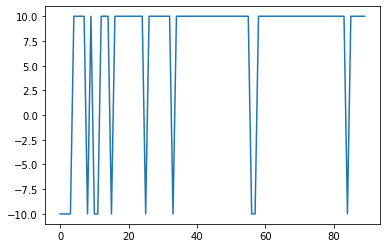

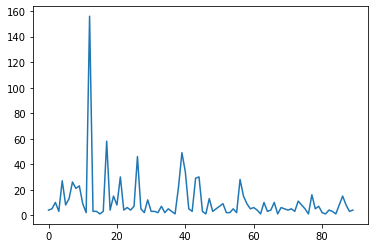

Iteration :  0
1/1 [==============================] - 0s 168ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 123ms/step
Iteration :  1
1/1 [==============================] - 0s 44ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 43ms/step
Iteration :  2
1/1 [==============================] - 0s 41ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 45ms/step
Iteration :  3
1/1 [==============================] - 0s 50ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


1/1 [==============================] - 0s 35ms/step
Iteration :  4
1/1 [==============================] - 0s 41ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [====================

1/1 [==============================] - 0s 51ms/step
Iteration :  80
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 37ms/step
Iteration :  81
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  82
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 41ms/step
Iteration :  83
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 38ms/step
Iteration :  84
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_'

1/1 [==============================] - 0s 43ms/step
Iteration :  120
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 37ms/step
Iteration :  121
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 41ms/step
Iteration :  122
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 37ms/step
Iteration :  123
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 44ms/step
Iteration :  124
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_'

1/1 [==============================] - 0s 37ms/step
Iteration :  160
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


Une bonne récompense
Iteration :  161
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 33ms/step
Iteration :  162
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 53ms/step
Iteration :  163
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 37ms/step
Iteration :  164
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_'

1/1 [==============================] - 0s 38ms/step
Iteration :  200
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 37ms/step
Iteration :  201
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  202
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 37ms/step
Iteration :  203
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 41ms/step
Iteration :  204
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_'

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  240
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 36ms/step
Iteration :  241
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 42ms/step
Iteration :  242
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 36ms/step
Iteration :  243
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  244
1/1 [============

['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 42ms/step
Iteration :  319
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 42ms/step
Iteration :  320
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 46ms/step
Iteration :  321
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 43ms/step
Iteration :  322
1/1 [==============================] - 0s 50ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  323
1/1 [============

1/1 [==============================] - 0s 43ms/step
Iteration :  398
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 44ms/step
Iteration :  399
1/1 [==============================] - 0s 42ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 35ms/step
Iteration :  400
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


Une bonne récompense
Iteration :  401
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  402
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X'

1/1 [==============================] - 0s 46ms/step
Iteration :  478
1/1 [==============================] - 0s 49ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
Iteration :  479
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


1/1 [==============================] - 0s 57ms/step
Iteration :  480
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 50ms/step
Iteration :  481
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 45ms/step
Iteration :  482
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_'

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 53ms/step
Iteration :  518
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 41ms/step
Iteration :  519
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 54ms/step
Iteration :  520
1/1 [==============================] - 0s 51ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 61ms/step
Iteration :  521
1/1 [==============================] - 0s 54ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 50ms/step
Iteration :  522
1/1 [============

1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 42ms/step
Iteration :  558
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 52ms/step
Iteration :  559
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 44ms/step
Iteration :  560
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 35ms/step
Iteration :  561
1/1 [==============================] - 0s 76ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [=============================

KeyboardInterrupt: 

In [8]:
#For 1000 
world = GridWorld()
scores, steps = ddqn(world, max_iter = 1000)
plt.plot(scores)
plt.show()
plt.plot(steps)
plt.show()

In [ ]:
#For 10000
world = GridWorld()
scores, steps = ddqn(world, max_iter = 10000)
plt.plot(scores)
plt.show()
plt.plot(steps)
plt.show()